# Idea for reversal of impact chain - glaciers



**Newer version: v2024-03-26**

**Some additional information:**
- we used LOWESS fits
    - originally done to create these figures here https://github.com/lilianschuster/glacier-model-projections-until2300
        - LOWESS fits done with the MOEPY package -> https://ayrtonb.github.io/Merit-Order-Effect/ug-08-lowess-quick-start/#quantile
        - we computed percentiles from 1 to 99th percentile in "1%" steps, but if you want others, we can create other percentiles... 
- global mean warming here defined as done in IPCC AR6 WG1, that means:
    - assume 0.69Â°C warming from preindustrial levels (1850-1900) to 1986-2005 for every GCM, then use the warming as given by individual GCMs ... 
- That means we use some glacier model data from in total two glacier models (will be updated to have three glacier models...). 
- Fits were done for all CMIP5 and CMIP6 GCMs going until 2100
    - some glacier models have done projections with more GCMs than others .... 
    - should be sufficient to analyse if this could be a good example


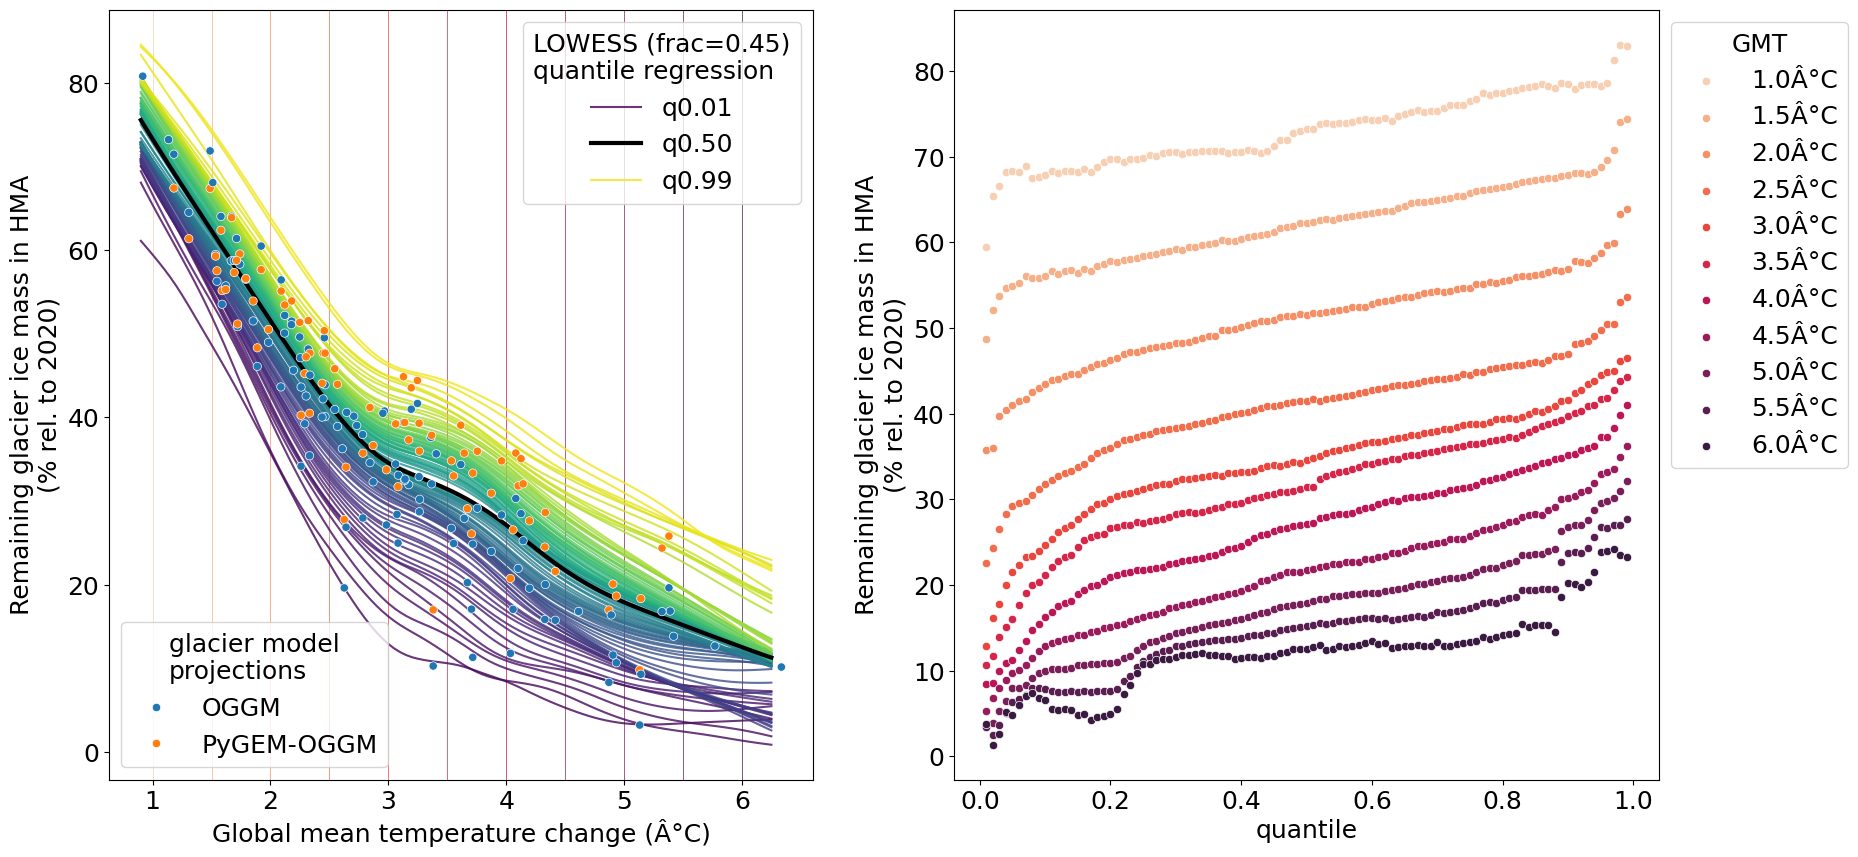

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.rc('font', size=18)

pd_raw_data_sel = pd.read_csv('glacier_model_proj_from_GCMs_until_2100_test_RGI13-14-15_2100_v2024-03-26_OGGM_PyGEM.csv', index_col=[0])
pd_fit = pd.read_csv('lowess_fit_from_GCMs_until_2100_RGI13-14-15_2100_OGGM_PyGEM_v2024-03-26.csv', index_col=[0])

quantiles_str = []
quantiles = np.arange(0.01,1,0.01)
for i in quantiles:
    _str = f'q{i:0.2f}' #.format(i)  # Format the percentile string with leading zeros
    quantiles_str.append(_str)
    
# revert the columns 
pd_fit.index = pd_fit.deltaTemp.values.round(2)
pd_fit_v = pd_fit[quantiles_str].T
pd_fit_v['q'] = quantiles


assert len(pd_fit.frac.unique())==1
frac = pd_fit.frac.unique()[0].round(2)
colors = sns.color_palette('viridis', n_colors=100)
colors_2 = sns.color_palette('rocket_r', n_colors=12)
plt.figure(figsize=(20,10))
plt.subplot(121)



for c,q in zip(colors,quantiles_str): 
    if q == 'q0.50':
        sns.lineplot(data=pd_fit, x='deltaTemp', y=q, color='black', label=q, lw=3, zorder=6)
    else:
        sns.lineplot(data=pd_fit, x='deltaTemp', y=q, color=c, label=q, alpha = 0.8, zorder=5)
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
leg = ax.legend([handles[0],handles[49], handles[-1]], [labels[0],labels[49], labels[-1]], title=f'LOWESS (frac={frac})\nquantile regression')
plt.ylabel('Remaining glacier ice mass in HMA\n(% rel. to 2020)')
plt.xlabel('Global mean temperature change (Â°C)')

_pd_sel = pd_raw_data_sel.loc[pd_raw_data_sel.region == 'RGI13-14-15']
_pd_sel = _pd_sel.loc[_pd_sel.year == 2100]
sns.scatterplot(data= _pd_sel, x= 'global_temp_ch_2071-2100_preindustrial', y='rel_ice_%_2020', hue='model', zorder=10)
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
leg2 = ax.legend(handles[-2:], labels[-2:], loc = 'lower left', title = 'glacier model\nprojections')
ax.add_artist(leg)
for j,t in enumerate(np.arange(1,6.5,0.5)):
    plt.axvline(t, lw=0.5,  color=colors_2[j])

plt.subplot(122)
for j,t in enumerate(np.arange(1,6.5,0.5)):
    sns.scatterplot(data=pd_fit_v, x= 'q', y= t, color=colors_2[j], label=f'{t}Â°C')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), title= 'GMT')
plt.xlabel('quantile')
plt.ylabel('Remaining glacier ice mass in HMA\n(% rel. to 2020)');

In [2]:
pd_fit_v

,0.9,0.95,1.0,1.05,1.1,1.15,1.2,1.25,1.3,1.35,...,5.85,5.9,5.95,6.0,6.05,6.1,6.15,6.2,6.25,q
q0.01,61.117968,60.296848,59.459620,58.599329,57.705887,56.757907,55.735012,54.636708,53.479908,52.288950,...,3.658958,3.689274,3.719591,3.749908,3.780225,3.810542,3.840860,3.871178,3.901497,0.01
q0.02,68.077787,66.724979,65.405038,64.111280,62.834035,61.565551,60.296389,59.015795,57.718117,56.391752,...,1.709415,1.591754,1.475536,1.362848,1.254437,1.150442,1.050990,0.956746,0.869886,0.02
q0.03,69.446021,68.027505,66.627601,65.247691,63.887944,62.549727,61.234524,59.940989,58.669983,57.421132,...,2.957623,2.855209,2.744341,2.623960,2.493327,2.352225,2.201513,2.042291,1.874951,0.03
q0.04,70.896714,69.557407,68.214509,66.870459,65.525812,64.178817,62.829184,61.478528,60.127253,58.773429,...,4.962827,5.008217,5.064755,5.128751,5.197437,5.268033,5.338314,5.407372,5.474337,0.04
q0.05,70.947163,69.628792,68.310591,66.991426,65.670788,64.347210,63.018744,61.682001,60.337503,58.989199,...,5.282893,5.128828,4.972666,4.814572,4.654608,4.492388,4.326784,4.157073,3.983193,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
q0.95,80.042994,79.176778,78.299517,77.409891,76.505807,75.587368,74.655613,73.712308,72.758438,71.793222,...,24.852972,24.543825,24.225256,23.897846,23.562836,23.221978,22.877013,22.529184,22.181303,0.95
q0.96,80.326890,79.496866,78.652886,77.796382,76.929060,76.052465,75.166489,74.270306,73.363067,72.443539,...,24.784476,24.508477,24.226923,23.938376,23.642031,23.337156,23.022972,22.698846,22.365283,0.96
q0.97,83.351093,82.309992,81.271585,80.234281,79.197039,78.159426,77.121600,76.083780,75.044621,74.002466,...,24.997419,24.723808,24.453647,24.188921,23.931623,23.682766,23.441571,23.205162,22.971133,0.97
q0.98,84.566844,83.836295,83.076314,82.287566,81.470967,80.627603,79.757827,78.862283,77.942347,76.999882,...,24.505132,24.150712,23.807898,23.476905,23.156633,22.845174,22.538724,22.233253,21.925511,0.98


In [3]:
pd_fit_v_sel

NameError: name 'pd_fit_v_sel' is not defined

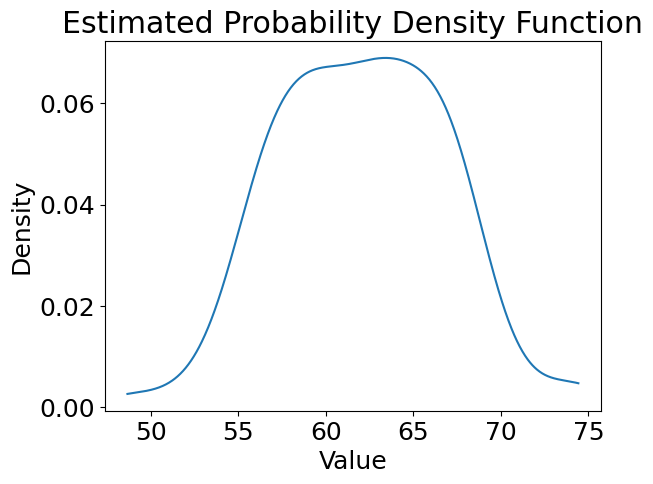

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# for 1.5
pd_fit_v_sel = pd_fit_v[1.5]

# Assuming you have a list of quantile values called quantile_values
quantile_values = np.array(pd_fit_v_sel.values)

# Estimate the density function using kernel density estimation
kde = gaussian_kde(quantile_values)

# Generate points to plot the estimated density function
x = np.linspace(np.min(quantile_values), np.max(quantile_values), 1000)
density_estimate = kde(x)

# Plot the estimated density function
plt.plot(x, density_estimate)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Estimated Probability Density Function')
plt.show()

In [ ]:
pd_fit_v

,0.9,0.95,1.0,1.05,1.1,1.15,1.2,1.25,1.3,1.35,...,5.85,5.9,5.95,6.0,6.05,6.1,6.15,6.2,6.25,q
q0.01,61.117968,60.296848,59.459620,58.599329,57.705887,56.757907,55.735012,54.636708,53.479908,52.288950,...,3.658958,3.689274,3.719591,3.749908,3.780225,3.810542,3.840860,3.871178,3.901497,0.01
q0.02,68.077787,66.724979,65.405038,64.111280,62.834035,61.565551,60.296389,59.015795,57.718117,56.391752,...,1.709415,1.591754,1.475536,1.362848,1.254437,1.150442,1.050990,0.956746,0.869886,0.02
q0.03,69.446021,68.027505,66.627601,65.247691,63.887944,62.549727,61.234524,59.940989,58.669983,57.421132,...,2.957623,2.855209,2.744341,2.623960,2.493327,2.352225,2.201513,2.042291,1.874951,0.03
q0.04,70.896714,69.557407,68.214509,66.870459,65.525812,64.178817,62.829184,61.478528,60.127253,58.773429,...,4.962827,5.008217,5.064755,5.128751,5.197437,5.268033,5.338314,5.407372,5.474337,0.04
q0.05,70.947163,69.628792,68.310591,66.991426,65.670788,64.347210,63.018744,61.682001,60.337503,58.989199,...,5.282893,5.128828,4.972666,4.814572,4.654608,4.492388,4.326784,4.157073,3.983193,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
q0.95,80.042994,79.176778,78.299517,77.409891,76.505807,75.587368,74.655613,73.712308,72.758438,71.793222,...,24.852972,24.543825,24.225256,23.897846,23.562836,23.221978,22.877013,22.529184,22.181303,0.95
q0.96,80.326890,79.496866,78.652886,77.796382,76.929060,76.052465,75.166489,74.270306,73.363067,72.443539,...,24.784476,24.508477,24.226923,23.938376,23.642031,23.337156,23.022972,22.698846,22.365283,0.96
q0.97,83.351093,82.309992,81.271585,80.234281,79.197039,78.159426,77.121600,76.083780,75.044621,74.002466,...,24.997419,24.723808,24.453647,24.188921,23.931623,23.682766,23.441571,23.205162,22.971133,0.97
q0.98,84.566844,83.836295,83.076314,82.287566,81.470967,80.627603,79.757827,78.862283,77.942347,76.999882,...,24.505132,24.150712,23.807898,23.476905,23.156633,22.845174,22.538724,22.233253,21.925511,0.98


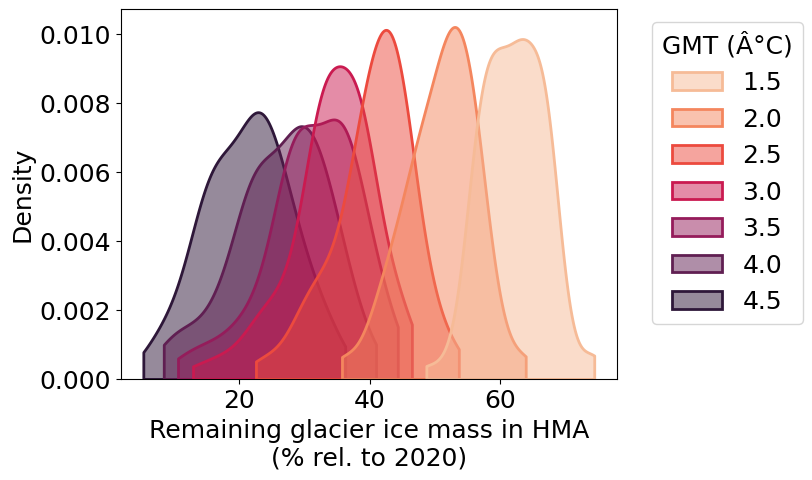

In [ ]:
sns.kdeplot(data=pd_fit_v[np.arange(1.5,5,0.5)], palette=sns.color_palette('rocket_r', n_colors=7), legend=True, cut=0,
           fill=True, alpha=0.5,lw=2)
plt.xlabel('Remaining glacier ice mass in HMA\n(% rel. to 2020)')
ax = plt.gca()
leg = ax.get_legend()
#handles, labels = ax.get_legend_handles_labels()
leg.set_bbox_to_anchor((1.4,1))
leg.set_title('GMT (Â°C)')

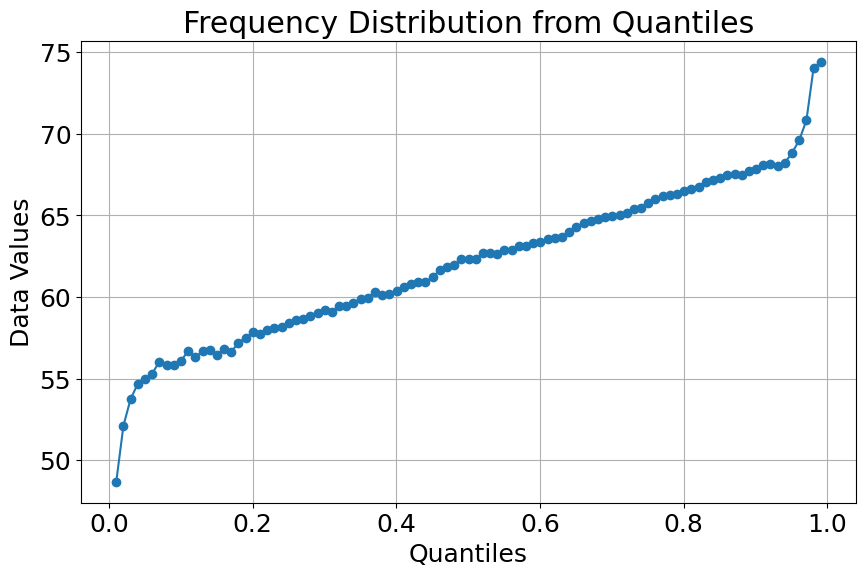

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Assuming corrected q and d arrays of the same length
q = np.linspace(0.01, 0.991, 99)  # Quantiles from 0.01 to 0.99
d = pd_fit_v_sel.values # np.linspace(1, 99, 99)  # Corresponding data values, adjust as per your data

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(q, d, marker='o')
plt.title('Frequency Distribution from Quantiles')
plt.xlabel('Quantiles')
plt.ylabel('Data Values')
plt.grid(True)
plt.show()


### added by peter

In [4]:
import glob
import xarray as xr
import collections
import seaborn as sns
import matplotlib
plt.rc('font', size=12)
matplotlib.rcParams['figure.figsize'] = (4,3)

In [5]:
# store pd_fit in an xarray
quantiles = xr.DataArray(pd_fit_v.T.values[:-1], dims=['gmt','q'], coords=dict(gmt=pd_fit_v.columns.values[:-1], q=[float(s[1:]) for s in pd_fit_v.index.values]))

In [6]:
def prob_greater_at_gmt(g, thresh):
    '''
    returns the probability of keeping the threshold amount of glacier at given GMT g
    '''
    y = quantiles.sel(gmt=g, method='nearest')
    return 1 - quantiles.q.values[np.abs(y - thresh).argmin()]

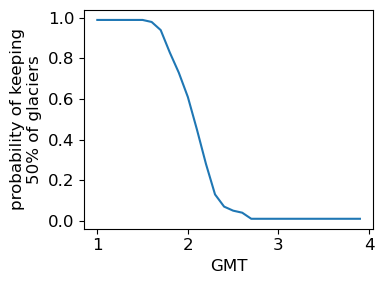

In [7]:
gmt_axis = np.arange(1,4,0.1)
p = np.array([prob_greater_at_gmt(g, 50) for g in gmt_axis])
plt.plot(gmt_axis, p)
plt.xlabel('GMT')
plt.ylabel('probability of keeping\n50% of glaciers')
plt.tight_layout()

# check gmt bias with robin

GMT:
1986-2005 vs 1850-1900 
1986-2005 should be 0.69K warmer than preindustrial
gmt -= gmt.loc[1986-2005].mean() + 0.69

In [8]:
def prob_greater_in_scenario(scen, thresh):
    '''
    returns the probability of crossing thresh in given scenario
    '''
    # get all gmt values in 2100 from the 2237 runs
    # bin GMT in 0.1 K steps
    # and count occurences in bins
    counter = collections.Counter(gmt.loc[scen].round(1).values)
    p = np.array([])
    # for each bin add the probability of crossing thresh at GMT level "count"-times
    for g,count in counter.items():
        p = np.append(p, [prob_greater_at_gmt(g, thresh)]*count)
    return p.mean()

In [9]:
year = 2100

In [10]:
gmt = xr.open_dataset(f'gmt_in_{year}.nc')['gmt']

In [12]:
# calculate the probability of keeping X% of the glacier for all 1500 scenarios
p_greater = xr.DataArray(dims=['scenario', 'thresh'], coords=dict(scenario=gmt.scenario.values, thresh=np.arange(40,70,10,'int')))
for thresh in p_greater.thresh.values:
    for scen in p_greater.scenario.values:
        p_greater.loc[scen, thresh] = prob_greater_in_scenario(scen, thresh)
xr.Dataset({'p_greater':p_greater}).to_netcdf(f'p_greater_in_{year}.nc')

In [11]:
p_greater = xr.open_dataset(f'p_greater_in_{year}.nc')['p_greater']

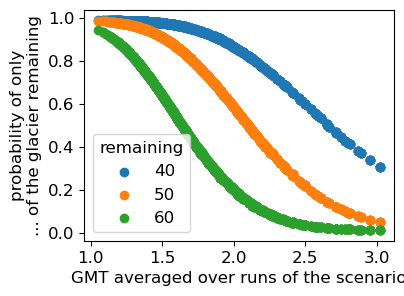

In [12]:
for thresh in p_greater.thresh.values[:]:
    plt.scatter(gmt.mean('run'),p_greater.loc[:,thresh], label=f'{thresh}')
plt.xlabel('GMT averaged over runs of the scenario')
plt.ylabel('probability of only\n... of the glacier remaining')
plt.legend(title='remaining')

In [13]:
# identify scenarios for which there is a 90% chance of keeping 40% of the glaciers
boundary_scenarios = p_greater.scenario[np.abs(p_greater.loc[:,40] - 0.90) < 0.01]

In [48]:
# identify scenarios for which there is a 90% chance of keeping 50% of the glaciers
boundary_scenarios = p_greater.scenario[np.abs(p_greater.loc[:,50] - 0.80) < 0.01]

In [49]:
boundary_scenarios

<xarray.DataArray 'scenario' (scenario: 40)>
array(['2030fact0.52_nz2080_ov-2500_meth0.75',
       '2030fact1.12_nz2070_ov-5000_meth0.1',
       '2030fact0.52_nz2100_ov-2500_meth0.25',
       '2030fact1.32_nz2050_ov-2500_meth0.75',
       '2030fact0.32_nz2090_ov-7500_meth0.9',
       '2030fact1.32_nz2050_ov-7500_meth0.9',
       '2030fact0.32_nz2080_ov0_meth0.9', '2030fact1.12_nz2060_ov0_meth0.25',
       '2030fact1.32_nz2060_ov-7500_meth0.5',
       '2030fact0.32_nz2090_ov-2500_meth0.9',
       '2030fact0.52_nz2100_ov-7500_meth0.25',
       '2030fact1.32_nz2060_ov-5000_meth0.25',
       '2030fact1.32_nz2050_ov0_meth0.5',
       '2030fact0.32_nz2090_ov-10000_meth0.9',
       '2030fact0.72_nz2080_ov-7500_meth0.5',
       '2030fact1.12_nz2070_ov-7500_meth0.1',
       '2030fact0.32_nz2090_ov-5000_meth0.9',
       '2030fact0.92_nz2060_ov-10000_meth0.9',
       '2030fact0.92_nz2070_ov-5000_meth0.5',
       '2030fact0.92_nz2060_ov-2500_meth0.75',
       '2030fact0.92_nz2050_ov-2500_meth0.9',
       '2030fact0.52_nz2080_ov0_meth0.75',
       '2030fact0.92_nz2070_ov-2500_meth0.25',
       '2030fact0.52_nz2100_ov0_meth0.25', '2030fact0.72_nz2050_ov0_meth0.9',
       '2030fact0.52_nz2100_ov-5000_meth0.25',
       '2030fact0.72_nz2070_ov-2500_meth0.75',
       '2030fact1.12_nz2070_ov-10000_meth0.25',
       '2030fact1.12_nz2060_ov-2500_meth0.5',
       '2030fact0.52_nz2070_ov-2500_meth0.9',
       '2030fact0.72_nz2080_ov0_meth0.25',
       '2030fact1.12_nz2050_ov-5000_meth0.9',
       '2030fact0.52_nz2060_ov0_meth0.9',
       '2030fact0.72_nz2080_ov-10000_meth0.5',
       '2030fact0.72_nz2080_ov-5000_meth0.5',
       '2030fact1.32_nz2060_ov-2500_meth0.1',
       '2030fact0.92_nz2070_ov0_meth0.1',
       '2030fact0.52_nz2100_ov-10000_meth0.25',
       '2030fact0.52_nz2090_ov0_meth0.5',
       '2030fact1.12_nz2060_ov-7500_meth0.75'], dtype='<U37')
Coordinates:
  * scenario  (scenario) <U37 '2030fact0.52_nz2080_ov-2500_meth0.75' ... '203...
    thresh    int64 50

Text(0.5, 0, 'GMST')

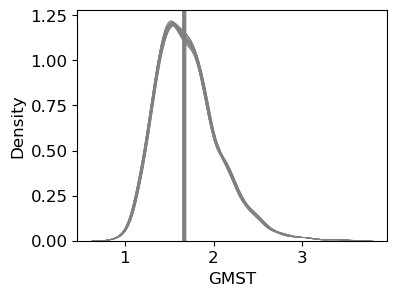

In [50]:
# GMT distributions for boundary scenarios in 2100
fig,ax = plt.subplots(nrows=1, figsize=(4,3))
for scen in boundary_scenarios:
    sns.kdeplot(gmt.loc[scen], color='gray', linewidth=0.3)
    ax.axvline(gmt.loc[scen].median(), color='gray', linewidth=0.3)
ax.set_xlabel('GMST')

In [51]:
# load fair emissions
emissions = pd.read_table('../Tier2_scenarios_emissions.csv', sep=',')
co2 = emissions.loc[(emissions.Variable == 'Emissions|CO2')]
co2 = xr.DataArray(co2.iloc[:,5:].values, dims=['scen','year'], coords=dict(scen=co2.Scenario, year=np.array(co2.columns[5:], 'int')))
ch4 = emissions.loc[(emissions.Variable == 'Emissions|CH4')]
ch4 = xr.DataArray(ch4.iloc[:,5:].values, dims=['scen','year'], coords=dict(scen=ch4.Scenario, year=np.array(ch4.columns[5:], 'int')))
cum_co2 = (co2.loc[:,2020:2100].rolling(year=2).sum() * 0.5 * 10).sum('year') / 1000

In [62]:
# select scenarios that stabilize in 2100
# -> no overshoot efore 2100
# -> potential for keeping the glacier mass later on as well
#selected_boundary_scenarios = boundary_scenarios[(co2.loc[boundary_scenarios].loc[:,2100] == 0) & (co2.loc[boundary_scenarios].loc[:,2090] > 0)]
selected_boundary_scenarios = boundary_scenarios[(co2.loc[boundary_scenarios].loc[:,2090] > 0)]
#selected_boundary_scenarios = boundary_scenarios[(co2.loc[boundary_scenarios].loc[:,:2100].min('year') >= -10)]
selected_boundary_scenarios

<xarray.DataArray 'scenario' (scenario: 5)>
array(['2030fact0.52_nz2100_ov-2500_meth0.25',
       '2030fact0.52_nz2100_ov-7500_meth0.25',
       '2030fact0.52_nz2100_ov0_meth0.25',
       '2030fact0.52_nz2100_ov-5000_meth0.25',
       '2030fact0.52_nz2100_ov-10000_meth0.25'], dtype='<U37')
Coordinates:
  * scenario  (scenario) <U37 '2030fact0.52_nz2100_ov-2500_meth0.25' ... '203...
    thresh    int64 50
    scen      (scenario) object '2030fact0.52_nz2100_ov-2500_meth0.25' ... '2...
    year      int64 2090

In [63]:
gmt_median = xr.open_dataset('gmt_median.nc')['gmt']

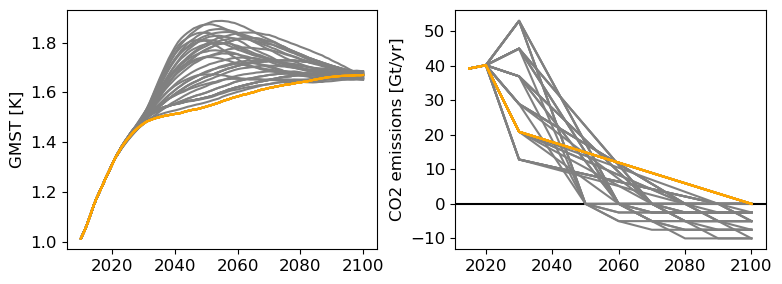

In [64]:

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
axes[1].axhline(0, color='k')
for scenarios, color in zip([boundary_scenarios, selected_boundary_scenarios], ['gray','orange']):
    for scen in scenarios.values:
        y = gmt_median.loc[scen,:2100]
        axes[0].plot(y.year, y, label=scen, color=color)
        y = co2.loc[scen,:2100] / 1000
        axes[1].plot(y.year, y, color=color)
    
axes[0].set_ylabel('GMST [K]')
axes[1].set_ylabel('CO2 emissions [Gt/yr]')
plt.tight_layout() 

In [34]:
# get cumulative CO2 emissions until 2100 in the orange scenario
CO2_budget = cum_co2.loc[selected_boundary_scenarios].values.mean()
CO2_budget

1034.4905389246612

In [ ]:
# get cumulative CO2 emissions until 2100 in the orange scenario
CO2_budget = cum_co2.loc[selected_boundary_scenarios].values.mean()
CO2_budget

1194.8766689905

In [21]:
emissions

,Model,Scenario,Region,Variable,Unit,2015,2020,2030,2040,2050,...,2210,2220,2230,2240,2250,2260,2270,2280,2290,2300
0,MESSAGE-GLOBIOM 1.0,2030fact0.12_nz2040_ov-10000_meth0.1,World,Emissions|BC,Mt BC/yr,9.727000,8.936683,5.645336,4.447852,3.402927,...,2.187436,2.187436,2.187436,2.187436,2.187436,2.187436,2.187436,2.187436,2.187436,2.187436
1,MESSAGE-GLOBIOM 1.0,2030fact0.12_nz2040_ov-10000_meth0.1,World,Emissions|CH4,Mt CH4/yr,388.072795,383.310854,169.376318,118.509035,128.887916,...,94.831917,94.831917,94.831917,94.831917,94.831917,94.831917,94.831917,94.831917,94.831917,94.831917
2,MESSAGE-GLOBIOM 1.0,2030fact0.12_nz2040_ov-10000_meth0.1,World,Emissions|CO,Mt CO/yr,934.349884,892.047875,646.369690,554.490064,441.725026,...,319.471923,319.471923,319.471923,319.471923,319.471923,319.471923,319.471923,319.471923,319.471923,319.471923
3,MESSAGE-GLOBIOM 1.0,2030fact0.12_nz2040_ov-10000_meth0.1,World,Emissions|CO2,Mt CO2/yr,39152.726298,40096.532516,4811.583902,0.000000,-5000.000000,...,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000
4,MESSAGE-GLOBIOM 1.0,2030fact0.12_nz2040_ov-10000_meth0.1,World,Emissions|CO2|AFOLU,Mt CO2/yr,3517.440000,3054.968434,-80.251661,-338.384225,-1634.458721,...,-1635.710190,-1635.710190,-1635.710190,-1635.710190,-1635.710190,-1635.710190,-1635.710190,-1635.710190,-1635.710190,-1635.710190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,MESSAGE-GLOBIOM 1.0,2030fact1.32_nz2200_ov0_meth0.9,World,Emissions|PFC|C6F14,kt C6F14/yr,1.330952,0.702248,0.412595,0.352702,0.208986,...,0.078526,0.078526,0.078526,0.078526,0.078526,0.078526,0.078526,0.078526,0.078526,0.078526
35996,MESSAGE-GLOBIOM 1.0,2030fact1.32_nz2200_ov0_meth0.9,World,Emissions|PFC|CF4,kt CF4/yr,16.051769,12.776570,5.228100,4.408441,8.946799,...,0.988551,0.988551,0.988551,0.988551,0.988551,0.988551,0.988551,0.988551,0.988551,0.988551
35997,MESSAGE-GLOBIOM 1.0,2030fact1.32_nz2200_ov0_meth0.9,World,Emissions|SF6,kt SF6/yr,5.458243,3.199794,3.401125,2.362182,1.636427,...,0.955984,0.955984,0.955984,0.955984,0.955984,0.955984,0.955984,0.955984,0.955984,0.955984
35998,MESSAGE-GLOBIOM 1.0,2030fact1.32_nz2200_ov0_meth0.9,World,Emissions|Sulfur,Mt SO2/yr,93.649189,81.812123,85.325855,65.011043,49.226110,...,17.485634,17.485634,17.485634,17.485634,17.485634,17.485634,17.485634,17.485634,17.485634,17.485634
